In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as scisig
import scipy.optimize as opt
from numba import jit, njit
import time
import scipy.io as sio

from scipy.signal import butter, lfilter

def butter_lowpass(highcut, fs, order=5):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = butter(order, high, btype='lowpass')
    return b, a


def butter_lowpass_filter(data, highcut, fs, order=5):
    b, a = butter_lowpass(highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_highpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = butter(order, low, btype='highpass')
    return b, a


def butter_highpass_filter(data, lowcut, fs, order=5):
    b, a = butter_highpass(lowcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def Linewidth2(x, a,  x0, gamma, c): #with noise floor
    return a*(gamma)/((x0**2 - x**2)**2+(x*gamma)**2) + c

In [3]:
import random
nump = int(1.4*10**(7))

np.random.seed(1235681)
randomlist = np.random.normal(0, 1, nump) # for thermal force

#seed
np.random.seed(9472518)
randomlist2 = np.random.normal(0, 1, nump) # for detection noise

In [176]:
@njit
def leapfrog_thermal(i, buf, y, w0, Fth, M, dt, rnd):
    # i is iteration we are on
    # x0 and v0 are initial position and velocity for this step
    # dt is timestep size
    # rnd is random number for this timestep
    tmpbuf = np.array([3*10**(-3), 0])
    xint = buf[0] + 0.5*buf[1]*dt
    v1 = buf[1]*(1 - y*dt) + Fth*rnd*dt - w0**2*xint*dt
    x1 = xint + 0.5*v1*dt
    tmpbuf[0] = x1
    tmpbuf[1] = v1
    return tmpbuf

@njit
def loop_itth(n, y, w0, Fth, M, dtn, randomlist):
    buf = np.array([3*10**(-3), 0])
    x = np.zeros(n)
    v = np.zeros(n)
    for i in range(n):
        buf = leapfrog_thermal(i, buf, y, w0, Fth, M, dtn, randomlist[i])
        x[i] = buf[0]
        v[i] = buf[1]
    return x, v

In [177]:
@njit
def leapfrog_thermal_charged_particle(i, buf, y, w0, Fth, M, dt, rnd, Q, r0, xoffset):
    # i is iteration we are on
    # x0 and v0 are initial position and velocity for this step
    # dt is timestep size
    # rnd is random number for this timestep
    # Q is particle charge
    # r0 is particle size
    # xoffset is particle position
    
    tmpbuf = np.zeros(2)
    xint = buf[0] + 0.5*buf[1]*dt
    if xint > r0+xoffset:
        v1 = buf[1]*(1 - y*dt) + Fth*rnd*dt - w0**2*xint*dt - Q/4/np.pi/(8.54*10**(-12))/(xint-xoffset)**2*2*1.6*10**(-19)*dt/M
    elif xint < -r0+xoffset:
        v1 = buf[1]*(1 - y*dt) + Fth*rnd*dt - w0**2*xint*dt + Q/4/np.pi/(8.54*10**(-12))/(xint-xoffset)**2*2*1.6*10**(-19)*dt/M
    else:
        v1 = buf[1]*(1 - y*dt) + Fth*rnd*dt - w0**2*xint*dt #- Q/4/np.pi/(8.54*10**(-12))/r0**2*2*1.6*10**(-19)*dt/M
    x1 = xint + 0.5*v1*dt
    tmpbuf[0] = x1
    tmpbuf[1] = v1
    return tmpbuf

@njit
def loop_itth_charged_particle(n, y, w0, Fth, M, dtn, randomlist, Q, r0, xoffset):
    buf = np.array([3*10**(-3), 0])
    x = np.zeros(n)
    v = np.zeros(n)
    for i in range(n):
        buf = leapfrog_thermal_charged_particle(i, buf, y, w0, Fth, M, dtn, randomlist[i], Q, r0, xoffset)
        x[i] = buf[0]
        v[i] = buf[1]
    return x, v

In [171]:
P = 0.1 # Pressure in mbar
T = 293 # Environmental temperature
R = (0.5*397)*10**(-9) # Particle Radius
p = 1850 # Particle Denisty
cn = 1 # Cluster size
w0 = 2*np.pi*11000 # oscillation frequency
dtn = 1*10**(-8) # Timestep
nump = int(5*10**6) # Number of points


# Other Variables
M = 212*1.67*10**(-27) # Ion mass
Reff = 168*10**(-12) # radius of ion
kb = 1.38*10**(-23) # Boltzmann constant
m = 29*1.67*10**(-27) # average mass of air particles
v = np.sqrt(8*1.38*10**(-23)*T/(np.pi*m)) # velocity of air particles
N0 = 2.43*10**(25) # Number density of air and ambient pressure
P0 = 1000 # Ambient pressure
N=N0*P/P0 # Number density of air at pressure P
y = (4/3*np.pi)*(m*v*N*Reff**2)/(M) # Damping from air
print(y/2/np.pi)
Fth =  np.sqrt(2*kb*T*y/M/dtn)# Thermal force noise

r0 = 1.5*10**(-6)

2883.911248478029


In [204]:
x, v = loop_itth(nump, y, w0, Fth, M, dtn, randomlist)

off1 = 0
off2 = 0.001
off3 = 0.002
off4 = 0.005

x2, v2 = loop_itth_charged_particle(nump, y, w0, Fth, M, dtn, randomlist, 10*1.6*10**(-19), r0, off1)
x3, v3 = loop_itth_charged_particle(nump, y, w0, Fth, M, dtn, randomlist, 10*1.6*10**(-19), r0, off2)
x4, v4 = loop_itth_charged_particle(nump, y, w0, Fth, M, dtn, randomlist, 10*1.6*10**(-19), r0, off3)
x5, v5= loop_itth_charged_particle(nump, y, w0, Fth, M, dtn, randomlist, 10*1.6*10**(-19), r0, off4)

0.01


Text(0.5, 0, 'Time (s)')

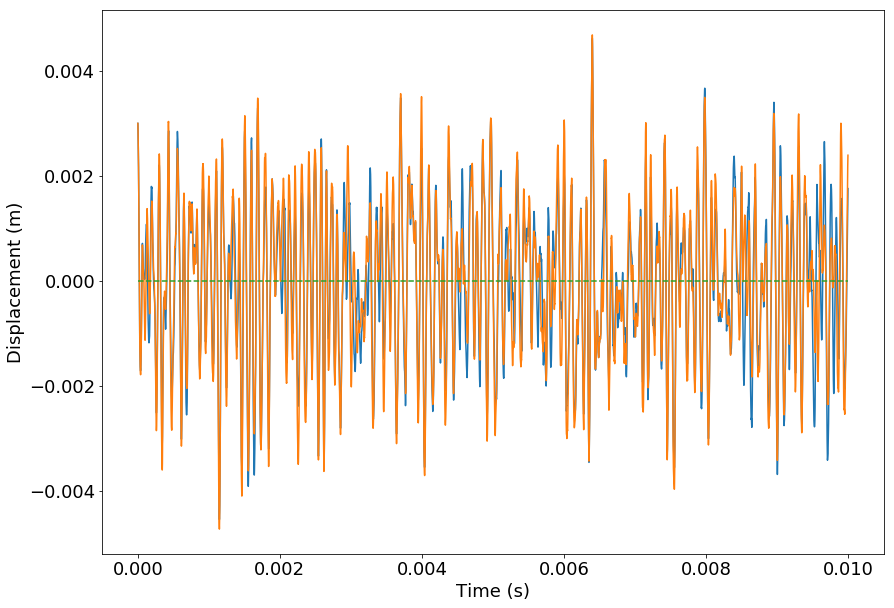

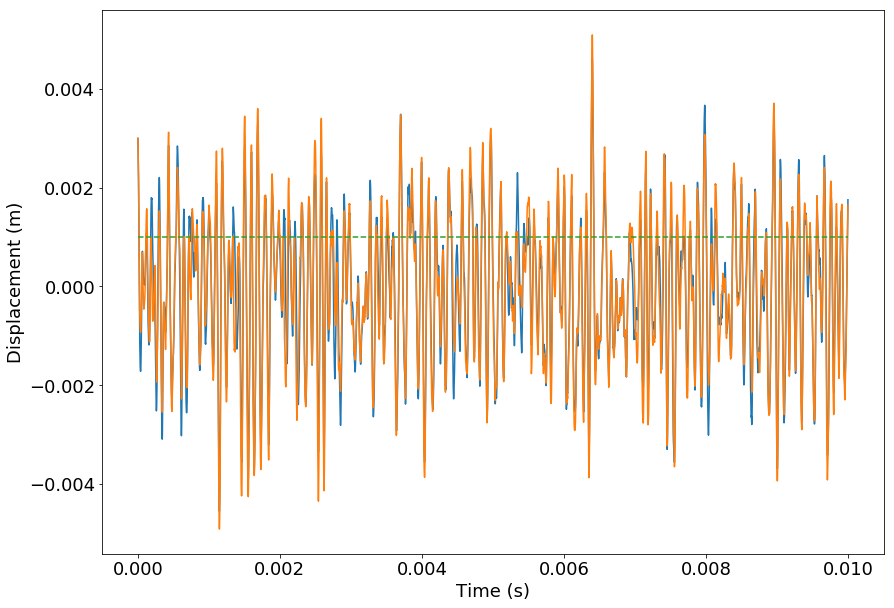

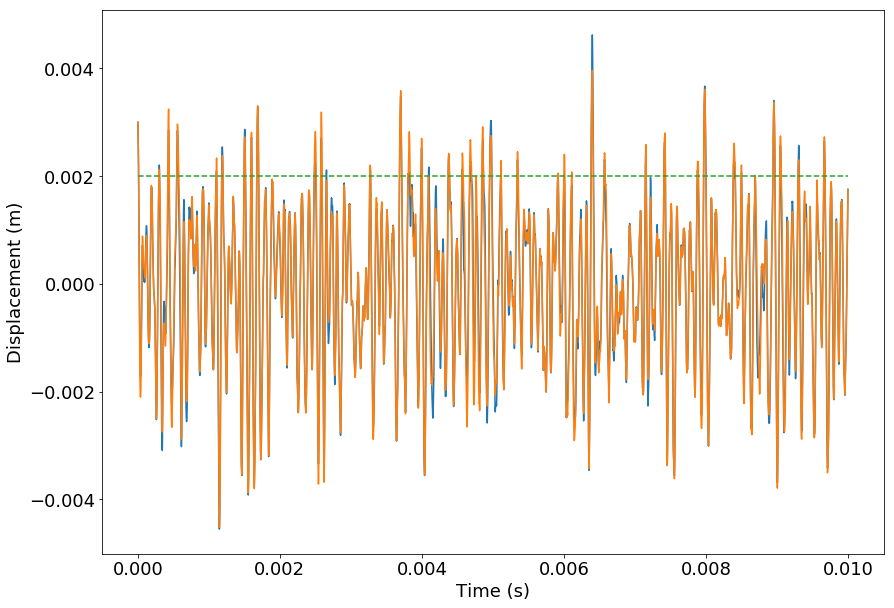

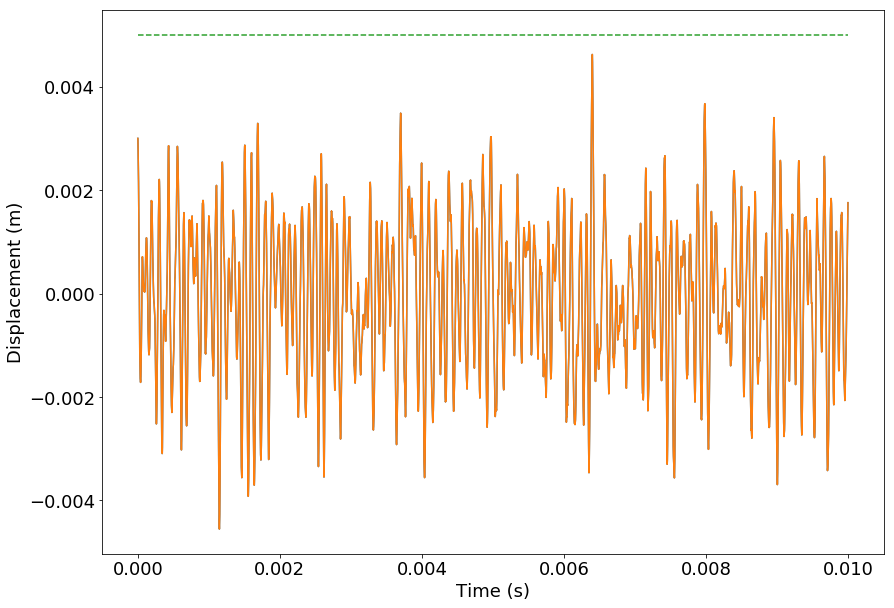

In [205]:
lb = 0
ub = 1000000
print(ub*dtn)
time = np.linspace(0, ub*dtn, ub)
u = 100

plt.figure(figsize = (14, 10))
plt.plot(time[lb:ub:u], x[lb:ub:u])
plt.plot(time[lb:ub:u], x2[lb:ub:u])
plt.plot([time[lb], time[ub-1]], [off1, off1], '--')
plt.ylabel('Displacement (m)')
plt.xlabel('Time (s)')

plt.figure(figsize = (14, 10))
plt.plot(time[lb:ub:u], x[lb:ub:u])
plt.plot(time[lb:ub:u], x3[lb:ub:u])
plt.plot([time[lb], time[ub-1]], [off2, off2], '--')
plt.ylabel('Displacement (m)')
plt.xlabel('Time (s)')

plt.figure(figsize = (14, 10))
plt.plot(time[lb:ub:u], x[lb:ub:u])
plt.plot(time[lb:ub:u], x4[lb:ub:u])
plt.plot([time[lb], time[ub-1]], [off3, off3], '--')
plt.ylabel('Displacement (m)')
plt.xlabel('Time (s)')

plt.figure(figsize = (14, 10))
plt.plot(time[lb:ub:u], x[lb:ub:u])
plt.plot(time[lb:ub:u], x5[lb:ub:u])
plt.plot([time[lb], time[ub-1]], [off4, off4], '--')
plt.ylabel('Displacement (m)')
plt.xlabel('Time (s)')

In [206]:
print(np.mean(x))
print(np.mean(x2))
print(np.mean(x3))
print(np.mean(x4))

-1.68732549027615e-06
4.123607851875672e-06
-5.932171654505224e-06
-2.5578525070601384e-06


In [207]:
charge1 = 10
charge2 = 100
charge3 = 1000

x6, v6 = loop_itth_charged_particle(nump, y, w0, Fth, M, dtn, randomlist, charge1*1.6*10**(-19), r0, off2)
x7, v7 = loop_itth_charged_particle(nump, y, w0, Fth, M, dtn, randomlist, charge2*1.6*10**(-19), r0, off2)
x8, v8 = loop_itth_charged_particle(nump, y, w0, Fth, M, dtn, randomlist, charge3*1.6*10**(-19), r0, off2)

0.01


Text(0.5, 0, 'Time (s)')

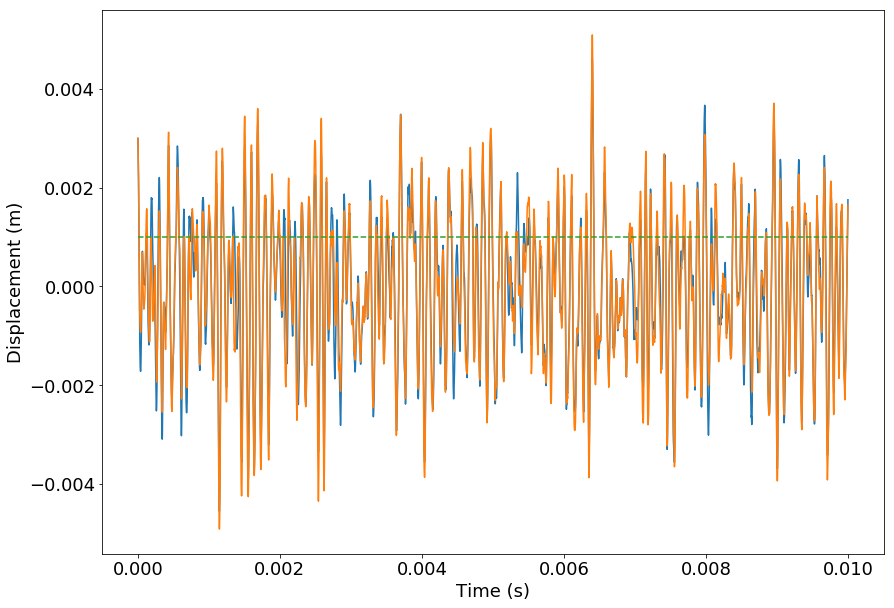

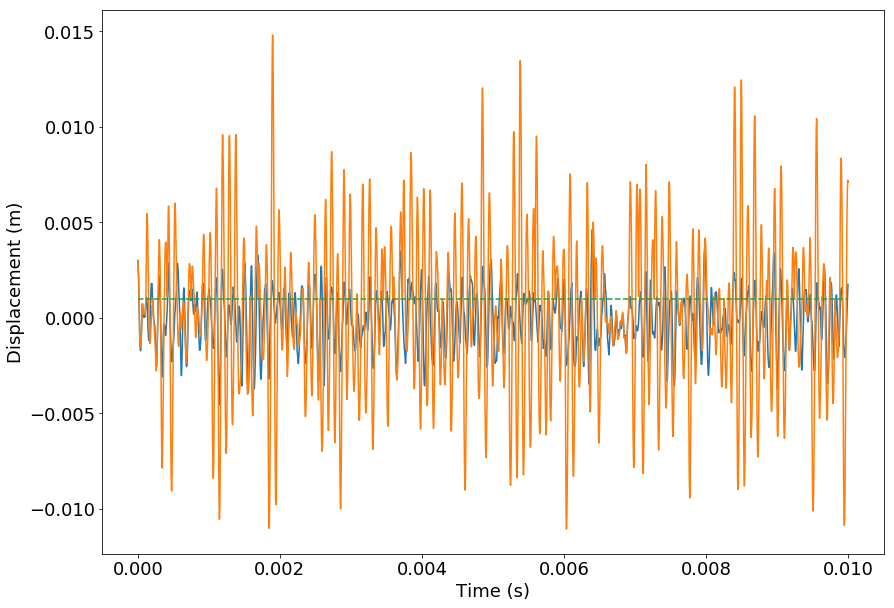

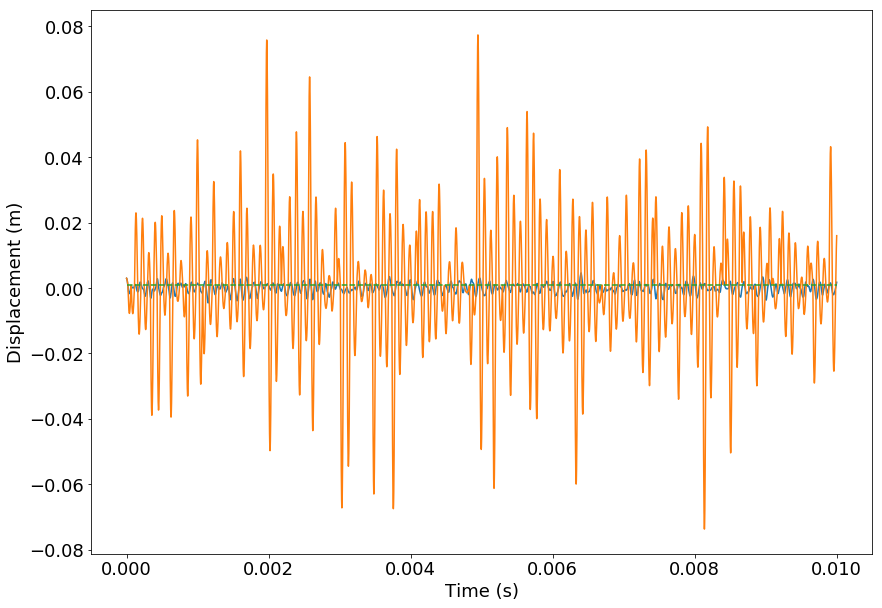

In [208]:
lb = 0
ub = 1000000
print(ub*dtn)
time = np.linspace(0, ub*dtn, ub)
u = 100

plt.figure(figsize = (14, 10))
plt.plot(time[lb:ub:u], x[lb:ub:u])
plt.plot(time[lb:ub:u], x6[lb:ub:u])
plt.plot([time[lb], time[ub-1]], [off2, off2], '--')
plt.ylabel('Displacement (m)')
plt.xlabel('Time (s)')

plt.figure(figsize = (14, 10))
plt.plot(time[lb:ub:u], x[lb:ub:u])
plt.plot(time[lb:ub:u], x7[lb:ub:u])
plt.plot([time[lb], time[ub-1]], [off2, off2], '--')
plt.ylabel('Displacement (m)')
plt.xlabel('Time (s)')

plt.figure(figsize = (14, 10))
plt.plot(time[lb:ub:u], x[lb:ub:u])
plt.plot(time[lb:ub:u], x8[lb:ub:u])
plt.plot([time[lb], time[ub-1]], [off2, off2], '--')
plt.ylabel('Displacement (m)')
plt.xlabel('Time (s)')


In [210]:
print(np.mean(x6))
print(np.mean(x7))
print(np.mean(x8))

-5.932171654505224e-06
1.9261450262890748e-05
0.00014989674118853123


In [48]:
def posdist(x, noise, filterBW, numbin, dtn):
    meanx = np.mean(x)
    R = (x - meanx - noise)**2
    R_filt = butter_lowpass_filter(R, filterBW, fs = 1/dtn, order = 2)
    hist = np.histogram(R_filt[1000:], numbin)
    PSDR = scisig.welch(R, fs = 1/dtn, nperseg = 0.01/dtn)
    PSDR_filt = scisig.welch(R_filt, fs = 1/dtn, nperseg = 0.01/dtn)
    return hist, R_filt, PSDR, PSDR_filt